

---

---




**Importam fisierul csv si redenumim coloanele**

---

---





In [39]:
import numpy as np
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/Proiect IMDB/"
df = pd.read_csv(path+'IMDB Dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
df = df.rename(columns={'review': 'text'})
df['sentiment'] = df['sentiment'].map({'negative':-1,'positive':1})



---


---


**Alegem un sample random de 2000 de texte pozitive si 2000 texte negative**

---


---





In [41]:
import pandas as pd

print(df['sentiment'].value_counts())

# Impart setul de date dupa sentiment (negativ si pozitiv)
df_negative = df[df['sentiment'] == -1]
df_positive = df[df['sentiment'] == 1]

min_samples = 2000

# Selectam random 2000 de exemple din fiecare sentiment
df_negative_sampled = df_negative.sample(n=min_samples, random_state=42)
df_positive_sampled = df_positive.sample(n=min_samples, random_state=42)

# Le combinam intr-un singur dataframe
df_sampled = pd.concat([df_negative_sampled, df_positive_sampled])

# Amestecam randurile
df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_sampled['sentiment'].value_counts())

df_sampled


sentiment
 1    25000
-1    25000
Name: count, dtype: int64
sentiment
-1    2000
 1    2000
Name: count, dtype: int64


,text,sentiment
0,"This movie is a pathetic attempt, apparently, ...",-1
1,This show is really great. It's smart.It's fun...,1
2,"Debbie Reynolds toe-taps, tangos and, yes, tap...",-1
3,MISSISSIPPI MERMAID is a disturbing and unsett...,1
4,"Like almost everyone, I am familiar with the m...",1
...,...,...
3995,"The opening of ""The Jungle"" promises us a safa...",-1
3996,"I'm afraid this one is pretty dreadful, despit...",-1
3997,Feh. This movie started out in an interesting ...,-1
3998,This Christmas gift arrived courtesy of TCM. W...,1




---



---
**Analiza setului de date**


---



---




<Axes: xlabel='sentiment'>

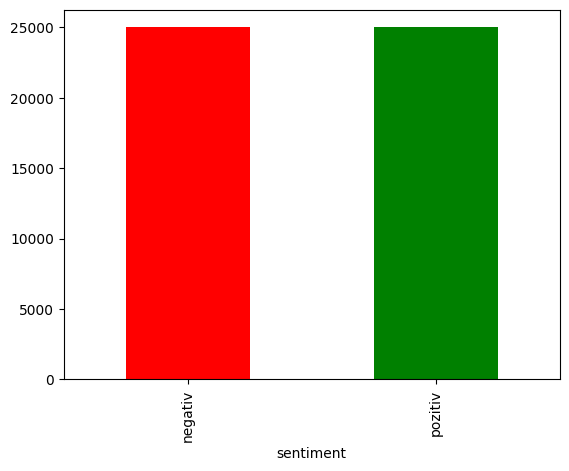

In [42]:
import matplotlib.pyplot as plt

label_map = {-1: "negativ", 1: "pozitiv"}
sentiment_counts = df["sentiment"].value_counts().sort_index()
sentiment_counts.index = sentiment_counts.index.map(label_map)
sentiment_counts.plot(kind="bar", color=["red", "green"])

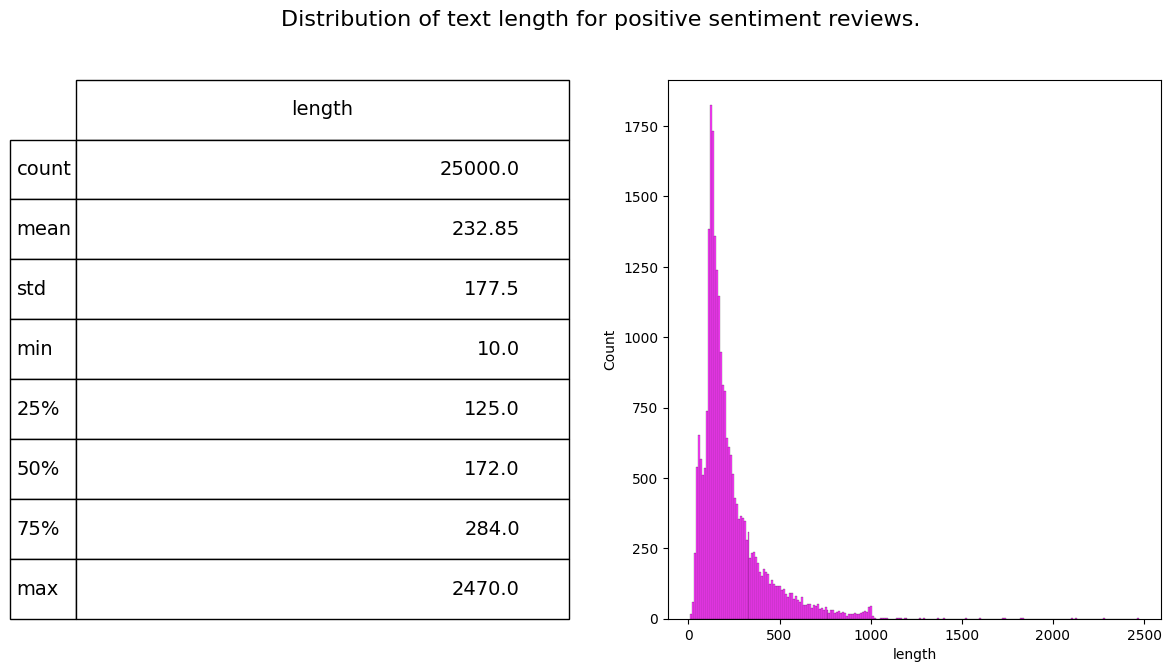

In [43]:
import seaborn as sns

review_len = pd.Series([len(review.split()) for review in df['text']])

fig = plt.figure(figsize=(14,7))
df['length'] = df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']==1]['length'], ax=ax1,color='magenta')
describe = df.length[df.sentiment==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.', fontsize=16)

plt.show()

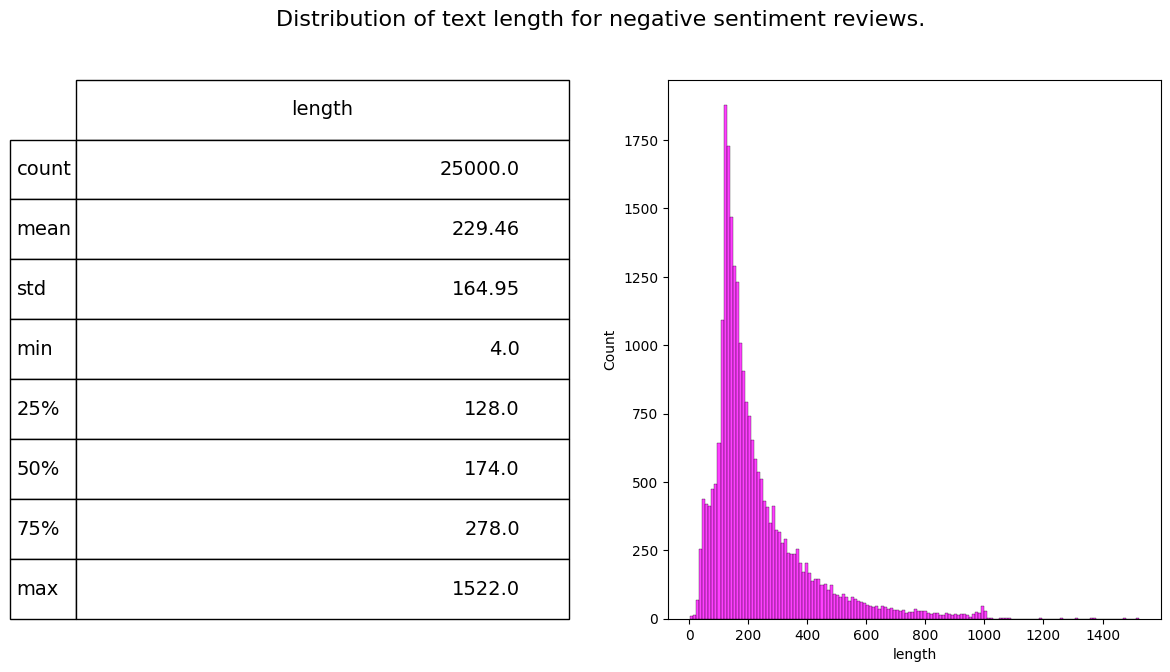

In [44]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']==-1]['length'], ax=ax1,color='magenta')
describe = df.length[df.sentiment==-1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment reviews.', fontsize=16)

plt.show()

In [45]:
import plotly.express as px
fig = px.pie(df, names='sentiment', title ='Pie chart of different sentiments of reviews')
fig.show()



---



---


**Prelucrarea textului si antrenarea modelului cu LogisticRegression**


---



---



In [47]:
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# incarcam modelul spaCy pentru tokenizare pt limba engleza
nlp = spacy.load("en_core_web_sm")

# initializa lematizatorul
lemmatizer = WordNetLemmatizer()

# lista cu negatii comune
# vreau sa imi pastreze negatiile in text
negations = {"not", "no", "n't", "isn't", "aren't", "won't", "can't", "never", "nothing"}

def review_to_words(review):
    ''' Convert review text into a sequence of words '''

    # elimina tagurile și hashtagurile (@ și #)
    review = re.sub(r"(@[A-Za-z0-9_]+)|(#\S+)", "", review)

    # convertirea la litere mici
    review = review.lower()

    # elimina tagurile HTML (ex: <br>, <br/>, <i>, etc.)
    review = re.sub(r"<.*?>", " ", review)

    # elimina caracterele non-alfabetic (vreau doar litere și numere)
    review = re.sub(r"[^a-zA-Z0-9]", " ", review)

    # foloseste spaCy pentru tokenizare
    doc = nlp(review)
    words = [token.text for token in doc]

    # elimina stopwords din lista de cuvinte, dar pastrez negatiile
    words = [w for w in words if w not in stopwords.words("english") or w in negations]

    # elimina cuvintele care sunt doar spatii
    words = [w for w in words if w.strip() != ""]

    # lematizeaza cuvintele
    lemmatized_words = []
    for word in words:
        # determinam POS pentru fiecare cuvant
        pos_tag = nltk.pos_tag([word])[0][1].lower()[0]  # adauga doar prima litera a tag-ului POS
        # lematizare tinand cont de POS (verbe, substantive, adverbe, etc.)
        lemmatized_words.append(lemmatizer.lemmatize(word, pos=pos_tag if pos_tag in "nvar" else 's'))

    # returneaza cuvintele lematizate sub forma de text (string)
    return " ".join(lemmatized_words)

# aplica functia pe fiecare rand din dataframe
df_sampled['processed_text'] = df_sampled['text'].apply(review_to_words)

# verifica daca preprocesarea a funcționat corect
print(df_sampled[['text', 'processed_text']].head())

# 1. vectorizarea textului folosind TF-IDF cu bigrames
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Folosește unigramuri și bigrame
X = vectorizer.fit_transform(df_sampled['processed_text'])

# 2. pregatirea etichetelor (sentimentul)
# asumam ca sentimentul este -1, 1 in coloana 'sentiment'
y = df_sampled['sentiment']

# 3. impartirea setului de date in seturi de antrenament si test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. antrenarea modelului Logistic Regression cu regularizare
# C ajustat pentru regularizare
model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0)
model.fit(X_train, y_train)

# 5. Evaluarea modelului
y_pred_lr = model.predict(X_test)
y_true_lr = y_test

# Afișăm raportul de clasificare și acuratețea
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  \
0  This movie is a pathetic attempt, apparently, ...   
1  This show is really great. It's smart.It's fun...   
2  Debbie Reynolds toe-taps, tangos and, yes, tap...   
3  MISSISSIPPI MERMAID is a disturbing and unsett...   
4  Like almost everyone, I am familiar with the m...   

                                      processed_text  
0  movie pathetic attempt apparently justify acti...  
1  show really great smart funny great act write ...  
2  debbie reynolds toe tap tango yes tap dance wa...  
3  mississippi mermaid disturb unsettle examinati...  
4  like almost everyone familiar music ray charle...  
Accuracy: 0.8483333333333334

Classification Report:
               precision    recall  f1-score   support

          -1       0.87      0.83      0.85       616
           1       0.83      0.86      0.85       584

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighte



---

False positives and false negatives


---



In [48]:
# refacem indexul pentru a ne asigura ca se potriveste cu X_test
df_test = df_sampled.iloc[y_test.index].copy()
df_test["true_label"] = y_test.values
df_test["predicted_label"] = y_pred_lr

# false positives: modelul a prezis pozitiv (1), dar adevarul era negativ (-1)
false_positives = df_test[(df_test["true_label"] == -1) & (df_test["predicted_label"] == 1)]

# false negatives: modelul a prezis negativ (-1), dar adevarul era pozitiv (1)
false_negatives = df_test[(df_test["true_label"] == 1) & (df_test["predicted_label"] == -1)]

# afisam cateva exemple din fiecare
print("FALSE POSITIVES (predicted 1, true -1):")
print(false_positives[["text", "true_label", "predicted_label"]].head(5))

print("\nFALSE NEGATIVES (predicted -1, true 1):")
print(false_negatives[["text", "true_label", "predicted_label"]].head(5))
df_test.iloc[527]

FALSE POSITIVES (predicted 1, true -1):
                                                   text  true_label  \
527   The problem with family dramas is that, outsid...          -1   
2989  Remember the good ol' animated batman show fro...          -1   
2540  This film gives a look at the suffering a fami...          -1   
2383  Julia (Kristina Copeland) travels with her hus...          -1   
3148  I watched this film for 45 minutes and counted...          -1   

      predicted_label  
527                 1  
2989                1  
2540                1  
2383                1  
3148                1  

FALSE NEGATIVES (predicted -1, true 1):
                                                   text  true_label  \
555   I gave it an 8 only because it had received su...           1   
594   Rene Clair's groundbreaking musical. If you wa...           1   
3590  This picks up about a year after the events in...           1   
2131  While not quite as good as A Murder is Announc...         

,1839
text,"Possibly John Cassavetes best film to date, an..."
sentiment,1
processed_text,possibly john cassavetes best film date defini...
true_label,1
predicted_label,1




---



---


**Prelucrarea textului si antrenarea modelului cu Dependancy tree**


---


---




In [49]:
import pandas as pd
import numpy as np
import re
import spacy
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# descărcare resurse
nltk.download('stopwords')
nltk.download('wordnet')

# inițializări
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

# curățare HTML + litere mici + eliminare caractere speciale
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    return text.lower()

# extragere subiect-verb-obiect
def extract_dependency_features(text):
    doc = nlp(text)
    triples = []
    for token in doc:
        if token.dep_ == "ROOT" and token.pos_ == "VERB":
            subject = [child for child in token.children if "subj" in child.dep_]
            obj = [child for child in token.children if "obj" in child.dep_ or "attr" in child.dep_]
            if subject and obj:
                s = subject[0].lemma_
                v = token.lemma_
                o = obj[0].lemma_
                triples.append(f"{s}_{v}_{o}")
    return " ".join(triples)

# preprocesare completă
def preprocess_with_dependencies(text):
    text_clean = clean_text(text)
    text_lemmas = [lemmatizer.lemmatize(word) for word in text_clean.split() if word not in stop_words]
    triple_features = extract_dependency_features(text)
    return " ".join(text_lemmas) + " " + triple_features

# presupunem că df_sampled există deja și are o coloană 'text'
df_sampled['processed_text_tree'] = df_sampled['text'].apply(preprocess_with_dependencies)

# vezi rezultatul
print(df_sampled[['text', 'processed_text_tree']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  \
0  This movie is a pathetic attempt, apparently, ...   
1  This show is really great. It's smart.It's fun...   
2  Debbie Reynolds toe-taps, tangos and, yes, tap...   
3  MISSISSIPPI MERMAID is a disturbing and unsett...   
4  Like almost everyone, I am familiar with the m...   

                                 processed_text_tree  
0  movie pathetic attempt apparently justify acti...  
1  show really great smart funny great acting wri...  
2  debbie reynolds toe tap tango yes tap dance wa...  
3  mississippi mermaid disturbing unsettling exam...  
4  like almost everyone familiar music ray charle...  


In [50]:
import pandas as pd
import numpy as np
import re
import spacy
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB  # model simplu pentru text

# descărcare resurse
nltk.download('stopwords')
nltk.download('wordnet')

# inițializări
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

# funcții auxiliare
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    return text.lower()

def extract_dependency_features(text):
    doc = nlp(text)
    triples = []
    for token in doc:
        if token.dep_ == "ROOT" and token.pos_ == "VERB":
            subject = [child for child in token.children if "subj" in child.dep_]
            obj = [child for child in token.children if "obj" in child.dep_ or "attr" in child.dep_]
            if subject and obj:
                s = subject[0].lemma_
                v = token.lemma_
                o = obj[0].lemma_
                triples.append(f"{s}_{v}_{o}")
    return " ".join(triples)

def preprocess_with_dependencies(text):
    text_clean = clean_text(text)
    text_lemmas = [lemmatizer.lemmatize(word) for word in text_clean.split() if word not in stop_words]
    triple_features = extract_dependency_features(text)
    return " ".join(text_lemmas) + " " + triple_features

# presupunem că df_sampled există și are coloana 'text' și 'sentiment'
df_sampled['processed_text_tree'] = df_sampled['text'].apply(preprocess_with_dependencies)

# vectorizare + clasificare simplă
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df_sampled['processed_text_tree'])
y = df_sampled['sentiment']

# împărțire în train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# clasificator simplu (Naive Bayes)
model = MultinomialNB()
model.fit(X_train, y_train)

# predicții și metrice
y_pred_tree = model.predict(X_test)
y_true_tree = y_test
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_tree))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Classification Report:

              precision    recall  f1-score   support

          -1       0.86      0.82      0.84       616
           1       0.82      0.85      0.84       584

    accuracy                           0.84      1200
   macro avg       0.84      0.84      0.84      1200
weighted avg       0.84      0.84      0.84      1200





---


False posive and false negative for depenadency tree.


---



In [51]:
# vectorizare tf-idf pentru preprocesarea cu dependency tree
vectorizer_tree = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tree = vectorizer_tree.fit_transform(df_sampled['processed_text_tree'])

# impartirea setului de date in train si test
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y, test_size=0.3, random_state=42)

# antrenam modelul logistic regression pe preprocesarea cu dependency tree
model_tree = LogisticRegression(max_iter=1000, class_weight='balanced')
model_tree.fit(X_tree_train, y_tree_train)

# predictii pentru setul de test
y_pred_tree = model_tree.predict(X_tree_test)

# obtinem indicii randurilor din df_sampled corespunzatoare setului de test
df_test_tree = df_sampled.iloc[y_tree_test.index].copy()
df_test_tree["true_label"] = y_tree_test.values
df_test_tree["predicted_label"] = y_pred_tree

# identificam false positives (fp) - cazurile unde modelul a prezis pozitiv, dar adevarul era negativ
false_positives_tree = df_test_tree[(df_test_tree["true_label"] == -1) & (df_test_tree["predicted_label"] == 1)]

# identificam false negatives (fn) - cazurile unde modelul a prezis negativ, dar adevarul era pozitiv
false_negatives_tree = df_test_tree[(df_test_tree["true_label"] == 1) & (df_test_tree["predicted_label"] == -1)]

# afisam 5 exemple de false positives pentru dependency tree
print("FALSE POSITIVES (Dependency Tree):")
print(false_positives_tree[["text", "true_label", "predicted_label"]].head(5))

# afisam 5 exemple de false negatives pentru dependency tree
print("\nFALSE NEGATIVES (Dependency Tree):")
print(false_negatives_tree[["text", "true_label", "predicted_label"]].head(5))

FALSE POSITIVES (Dependency Tree):
                                                   text  true_label  \
527   The problem with family dramas is that, outsid...          -1   
2989  Remember the good ol' animated batman show fro...          -1   
2540  This film gives a look at the suffering a fami...          -1   
2299  It is unbelievable that a script as cliché and...          -1   
3148  I watched this film for 45 minutes and counted...          -1   

      predicted_label  
527                 1  
2989                1  
2540                1  
2299                1  
3148                1  

FALSE NEGATIVES (Dependency Tree):
                                                   text  true_label  \
555   I gave it an 8 only because it had received su...           1   
594   Rene Clair's groundbreaking musical. If you wa...           1   
3590  This picks up about a year after the events in...           1   
2464  The movie was a big Car Commercial. :-)<br /><...           1   
109



---



---
**Compararea modelelor**


---



---



                                               Metric       Count
0              False Positives in Logistic Regression  103.000000
1              False Negatives in Logistic Regression   79.000000
2                  False Positives in Dependency Tree  105.000000
3                  False Negatives in Dependency Tree   75.000000
4       Only in Logistic Regression (False Positives)   11.000000
5       Only in Logistic Regression (False Negatives)   13.000000
6           Only in Dependency Tree (False Positives)   13.000000
7           Only in Dependency Tree (False Negatives)    9.000000
8   Percentage of False Positives Only in Logistic...    5.288462
9   Percentage of False Negatives Only in Logistic...    8.441558
10  Percentage of False Positives Only in Dependen...    6.250000
11  Percentage of False Negatives Only in Dependen...    5.844156


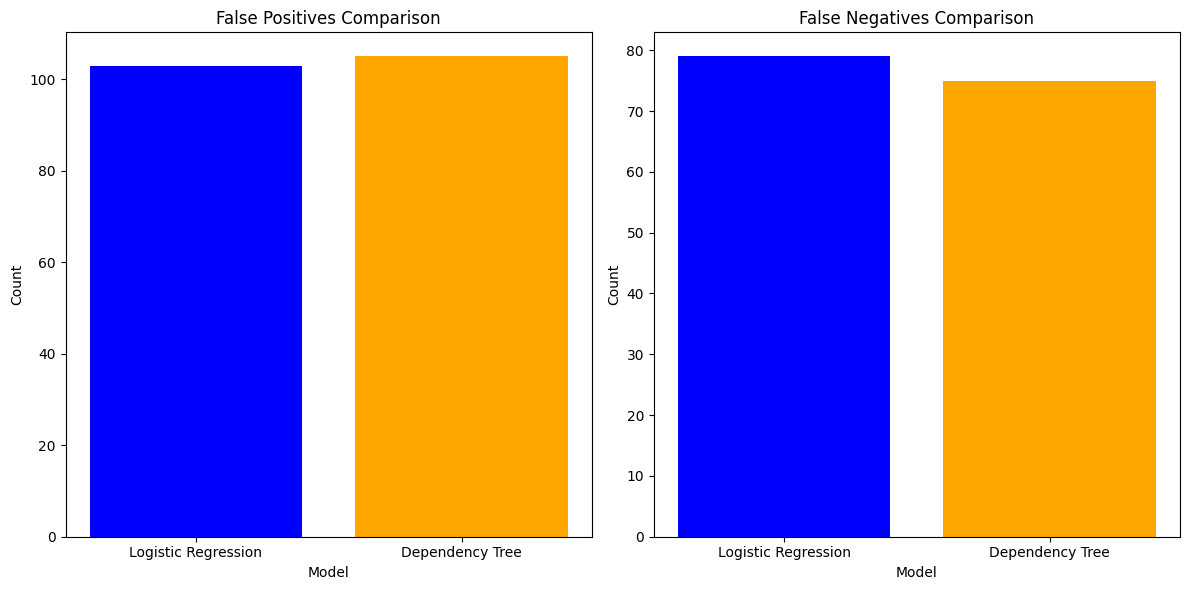

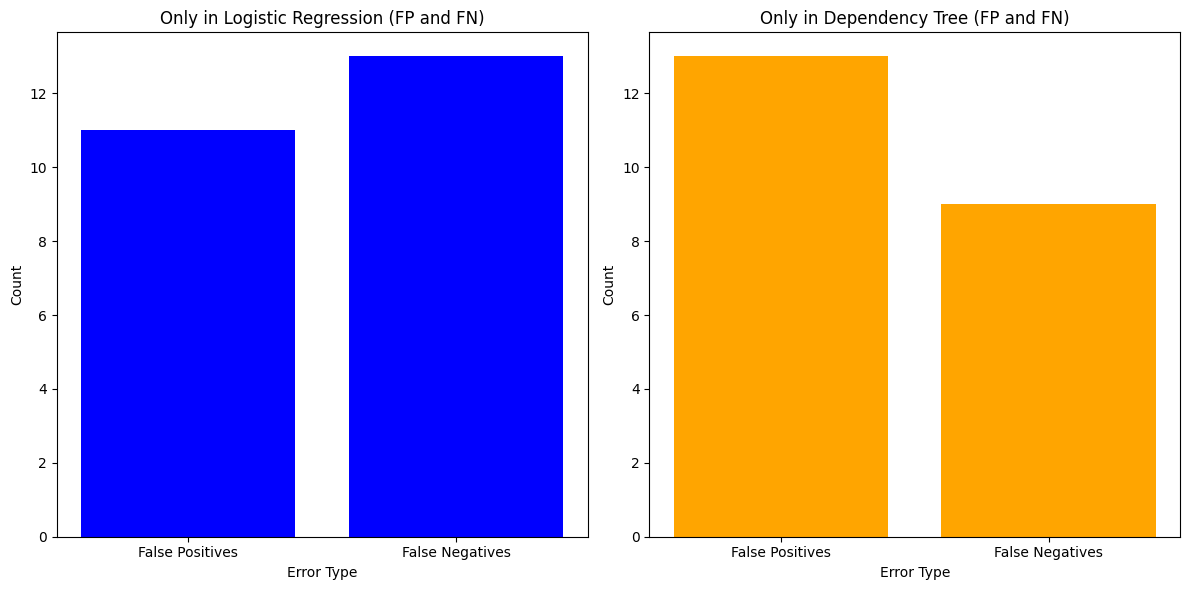

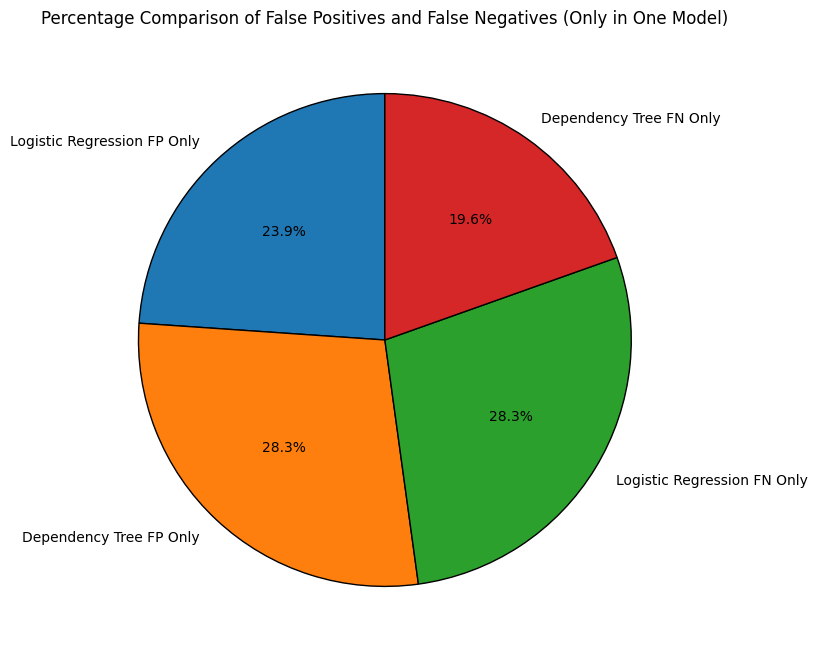

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# identificam false positives si false negatives pentru logistic regression
false_positives_lr = df_test[(df_test["true_label"] == -1) & (df_test["predicted_label"] == 1)]
false_negatives_lr = df_test[(df_test["true_label"] == 1) & (df_test["predicted_label"] == -1)]

# identificam false positives si false negatives pentru dependency tree
false_positives_tree = df_test_tree[(df_test_tree["true_label"] == -1) & (df_test_tree["predicted_label"] == 1)]
false_negatives_tree = df_test_tree[(df_test_tree["true_label"] == 1) & (df_test_tree["predicted_label"] == -1)]

# numarul de false positives si false negatives pentru fiecare abordare
false_pos_lr_count = len(false_positives_lr)
false_neg_lr_count = len(false_negatives_lr)
false_pos_tree_count = len(false_positives_tree)
false_neg_tree_count = len(false_negatives_tree)

# false positives si false negatives doar in logistic regression si nu in dependency tree
only_lr_false_pos = false_positives_lr[~false_positives_lr['text'].isin(false_positives_tree['text'])]
only_lr_false_neg = false_negatives_lr[~false_negatives_lr['text'].isin(false_negatives_tree['text'])]

# false positives si false negatives doar in dependency tree si nu in logistic regression
only_tree_false_pos = false_positives_tree[~false_positives_tree['text'].isin(false_positives_lr['text'])]
only_tree_false_neg = false_negatives_tree[~false_negatives_tree['text'].isin(false_negatives_lr['text'])]

# calculam procentele pentru fiecare
total_false_pos = false_pos_lr_count + false_pos_tree_count
total_false_neg = false_neg_lr_count + false_neg_tree_count

percent_only_lr_false_pos = (len(only_lr_false_pos) / total_false_pos) * 100 if total_false_pos > 0 else 0
percent_only_lr_false_neg = (len(only_lr_false_neg) / total_false_neg) * 100 if total_false_neg > 0 else 0

percent_only_tree_false_pos = (len(only_tree_false_pos) / total_false_pos) * 100 if total_false_pos > 0 else 0
percent_only_tree_false_neg = (len(only_tree_false_neg) / total_false_neg) * 100 if total_false_neg > 0 else 0

# cream un dataframe pentru comparatie
comparison_data = {
    "Metric": ["False Positives in Logistic Regression", "False Negatives in Logistic Regression",
               "False Positives in Dependency Tree", "False Negatives in Dependency Tree",
               "Only in Logistic Regression (False Positives)", "Only in Logistic Regression (False Negatives)",
               "Only in Dependency Tree (False Positives)", "Only in Dependency Tree (False Negatives)",
               "Percentage of False Positives Only in Logistic Regression",
               "Percentage of False Negatives Only in Logistic Regression",
               "Percentage of False Positives Only in Dependency Tree",
               "Percentage of False Negatives Only in Dependency Tree"],
    "Count": [false_pos_lr_count, false_neg_lr_count, false_pos_tree_count, false_neg_tree_count,
              len(only_lr_false_pos), len(only_lr_false_neg), len(only_tree_false_pos),
              len(only_tree_false_neg), percent_only_lr_false_pos, percent_only_lr_false_neg,
              percent_only_tree_false_pos, percent_only_tree_false_neg]
}

# convertim in dataframe
comparison_df = pd.DataFrame(comparison_data)

# afisam tabelul
print(comparison_df)

# cream graficele

# 1. bar chart pentru false positives si false negatives
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# bar chart pentru false positives
ax[0].bar(['Logistic Regression', 'Dependency Tree'], [false_pos_lr_count, false_pos_tree_count], color=['blue', 'orange'])
ax[0].set_title("False Positives Comparison")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Model")

# bar chart pentru false negatives
ax[1].bar(['Logistic Regression', 'Dependency Tree'], [false_neg_lr_count, false_neg_tree_count], color=['blue', 'orange'])
ax[1].set_title("False Negatives Comparison")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Model")

plt.tight_layout()
plt.show()

# 2. bar chart pentru fiecare model in parte (false positives si false negatives)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# logistic regression bar chart
ax[0].bar(['False Positives', 'False Negatives'], [len(only_lr_false_pos), len(only_lr_false_neg)], color='blue')
ax[0].set_title("Only in Logistic Regression (FP and FN)")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Error Type")

# dependency tree bar chart
ax[1].bar(['False Positives', 'False Negatives'], [len(only_tree_false_pos), len(only_tree_false_neg)], color='orange')
ax[1].set_title("Only in Dependency Tree (FP and FN)")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Error Type")

plt.tight_layout()
plt.show()

# pie chart pentru comparatia procentuala a erorilor
labels = ['Logistic Regression FP Only', 'Dependency Tree FP Only',
          'Logistic Regression FN Only', 'Dependency Tree FN Only']
sizes = [len(only_lr_false_pos), len(only_tree_false_pos),
         len(only_lr_false_neg), len(only_tree_false_neg)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
ax.set_title("Percentage Comparison of False Positives and False Negatives (Only in One Model)")
plt.show()




---



---
Transformers


---



---




In [53]:
# 1. Instalare pachete necesare (dacă nu ai făcut deja)
!pip uninstall -y transformers
!pip install transformers datasets -q
from transformers import TrainingArguments
import transformers
print(transformers.__version__)

Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
4.51.3


In [54]:
# 2. importuri
import os
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# dezactivam wandb (logging extern)
os.environ["WANDB_DISABLED"] = "true"

# 3. pregatire date
# conversie etichete: -1 -> 0 (negativ), 1 -> 1 (pozitiv)
df_test_bert = df_sampled.copy()
df_test_bert['label'] = df_test_bert['sentiment'].map({-1: 0, 1: 1})

# impartire train/test
train_df, test_df = train_test_split(df_test_bert, test_size=0.2, random_state=42, stratify=df_test_bert['label'])

# creare dataset huggingface
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# 4. tokenizer + mapare
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# 5. model si data collator
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 6. argumente pentru antrenare
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

# 7. trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# 8. antrenare model
trainer.train()

# 9. evaluare
preds_output = trainer.predict(test_dataset)
y_pred_bert = preds_output.predictions.argmax(-1)
y_true_bert = preds_output.label_ids

# reconstruim dataframe-ul cu predicții pentru transformers
df_test_bert = test_df.copy()

# adaugă coloanele cu etichete reale și prezise
df_test_bert["true_label"] = y_true_bert
df_test_bert["predicted_label"] = y_pred_bert

# mapează înapoi de la 0/1 la -1/1 dacă este necesar
df_test_bert["true_label"] = df_test_bert["true_label"].map({0: -1, 1: 1})
df_test_bert["predicted_label"] = df_test_bert["predicted_label"].map({0: -1, 1: 1})

print("\nclassification report:")
print(classification_report(y_true_bert, y_pred_bert, target_names=["Negative", "Positive"]))

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-54-5d56562415de>:50: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Step,Training Loss
10,0.694500
20,0.623900
30,0.472000
40,0.335500
50,0.363900
60,0.328300
70,0.411600
80,0.259200
90,0.460800
100,0.381700



classification report:
              precision    recall  f1-score   support

    Negative       0.92      0.91      0.91       400
    Positive       0.91      0.92      0.92       400

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.91       800
weighted avg       0.92      0.92      0.91       800



In [58]:
# reconstruim dataframe-ul cu predicții pentru transformers
df_test_bert = test_df.copy()

# adaugă coloanele cu etichete reale și prezise
df_test_bert["true_label"] = y_true_bert
df_test_bert["predicted_label"] = y_pred_bert

# mapează înapoi de la 0/1 la -1/1 dacă este necesar
df_test_bert["true_label"] = df_test_bert["true_label"].map({0: -1, 1: 1})
df_test_bert["predicted_label"] = df_test_bert["predicted_label"].map({0: -1, 1: 1})

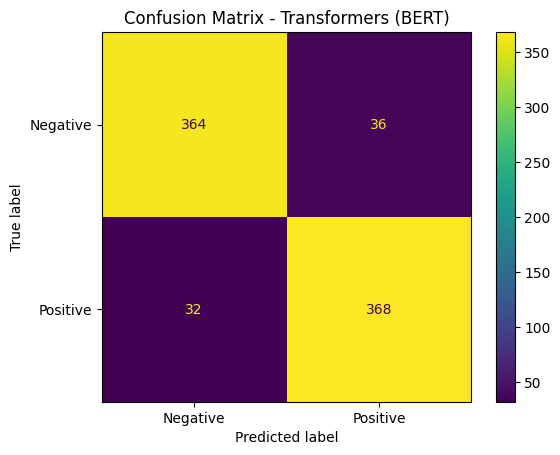

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true_bert, y_pred_bert, display_labels=["Negative", "Positive"])
plt.title("Confusion Matrix - Transformers (BERT)")
plt.show()


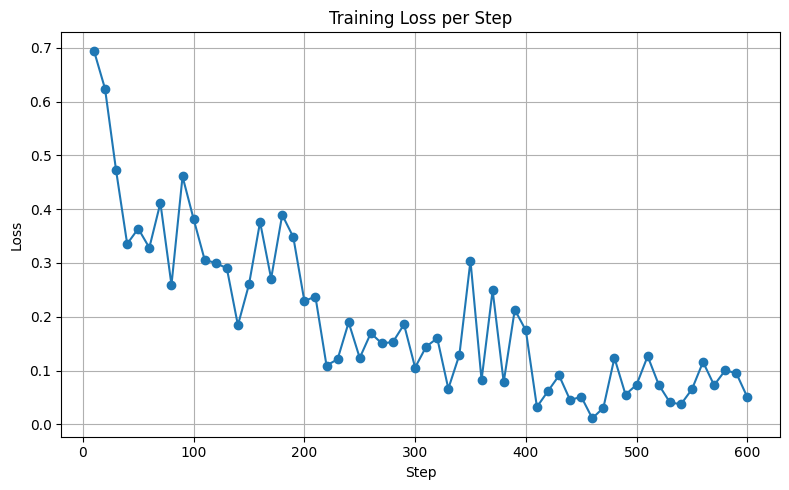

In [55]:
import matplotlib.pyplot as plt

# extragem logurile din trainer
log_history = trainer.state.log_history

# filtrăm doar intrările cu loss
steps = []
losses = []

for entry in log_history:
    if "loss" in entry and "epoch" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

# desenăm graficul
plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o')
plt.title("Training Loss per Step")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
import pandas as pd
from sklearn.metrics import classification_report

# presupunem ca ai deja urmatoarele predictii si etichete reale
# y_true_lr, y_pred_lr - logistic regression
# y_true_tree, y_pred_tree - dependency tree
# y_true_bert, y_pred_bert - transformers

# genereaza rapoarte
report_lr = classification_report(y_true_lr, y_pred_lr, target_names=["Negative", "Positive"], output_dict=True)
report_tree = classification_report(y_true_tree, y_pred_tree, target_names=["Negative", "Positive"], output_dict=True)
report_bert = classification_report(y_true_bert, y_pred_bert, target_names=["Negative", "Positive"], output_dict=True)

# functie pentru a extrage datele relevante
def extract_metrics(report, model_name):
    rows = []
    for cls in ["Negative", "Positive"]:
        row = {
            "Model": model_name,
            "Class": cls,
            "Precision": round(report[cls]["precision"], 2),
            "Recall": round(report[cls]["recall"], 2),
            "F1-Score": round(report[cls]["f1-score"], 2),
            "Support": int(report[cls]["support"])
        }
        rows.append(row)
    return rows

# construim tabela finala
data = []
data += extract_metrics(report_lr, "Logistic Regression")
data += extract_metrics(report_tree, "Dependency Tree")
data += extract_metrics(report_bert, "Transformers")

comparison_df = pd.DataFrame(data)

# afiseaza tabelul
print(comparison_df)

                 Model     Class  Precision  Recall  F1-Score  Support
0  Logistic Regression  Negative       0.87    0.83      0.85      616
1  Logistic Regression  Positive       0.83    0.86      0.85      584
2      Dependency Tree  Negative       0.87    0.83      0.85      616
3      Dependency Tree  Positive       0.83    0.87      0.85      584
4         Transformers  Negative       0.92    0.91      0.91      400
5         Transformers  Positive       0.91    0.92      0.92      400


                 Model       Error Type  Count
0  Logistic Regression  False Positives    103
1  Logistic Regression  False Negatives     79
2      Dependency Tree  False Positives    105
3      Dependency Tree  False Negatives     75
4         Transformers  False Positives     36
5         Transformers  False Negatives     32


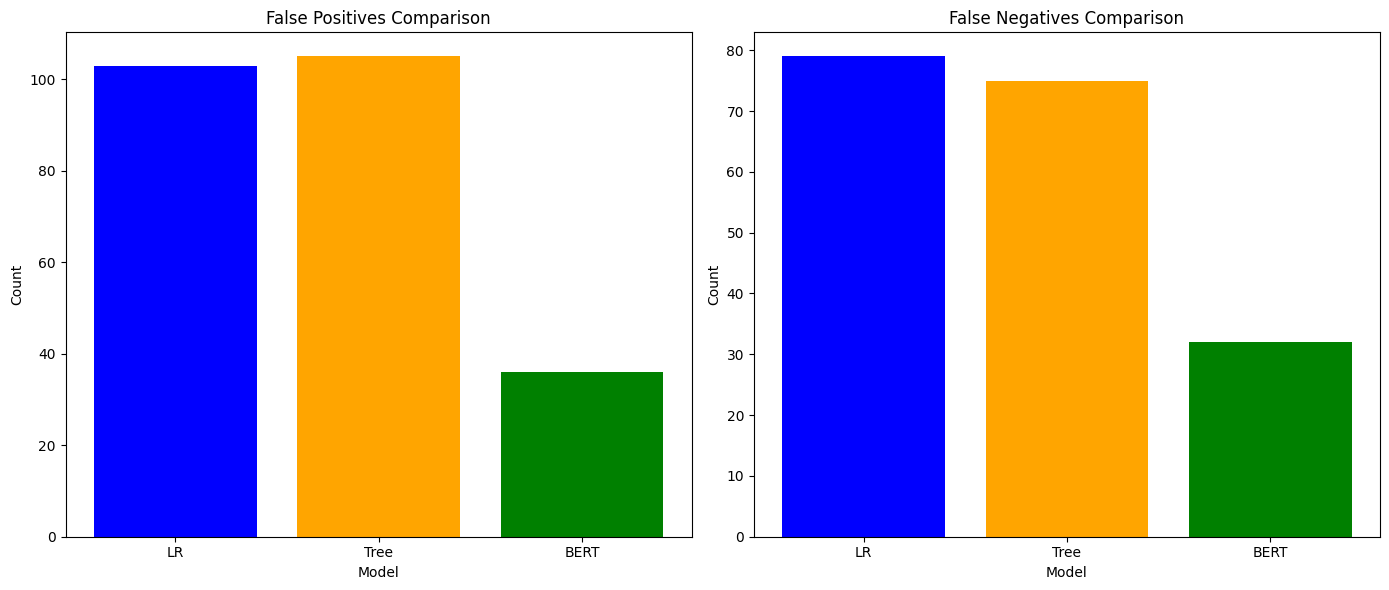

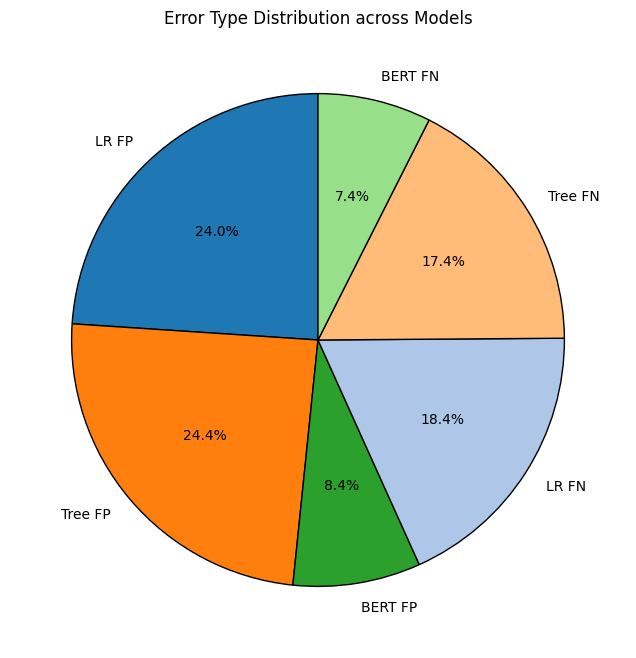

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# false positives si false negatives pentru logistic regression
false_positives_lr = df_test[(df_test["true_label"] == -1) & (df_test["predicted_label"] == 1)]
false_negatives_lr = df_test[(df_test["true_label"] == 1) & (df_test["predicted_label"] == -1)]

# dependency tree
false_positives_tree = df_test_tree[(df_test_tree["true_label"] == -1) & (df_test_tree["predicted_label"] == 1)]
false_negatives_tree = df_test_tree[(df_test_tree["true_label"] == 1) & (df_test_tree["predicted_label"] == -1)]

# transformers
false_positives_bert = df_test_bert[(df_test_bert["true_label"] == -1) & (df_test_bert["predicted_label"] == 1)]
false_negatives_bert = df_test_bert[(df_test_bert["true_label"] == 1) & (df_test_bert["predicted_label"] == -1)]

# numar total erori
false_pos_lr_count = len(false_positives_lr)
false_neg_lr_count = len(false_negatives_lr)
false_pos_tree_count = len(false_positives_tree)
false_neg_tree_count = len(false_negatives_tree)
false_pos_bert_count = len(false_positives_bert)
false_neg_bert_count = len(false_negatives_bert)

# creare dataframe comparativ
comparison_data = {
    "Model": ["Logistic Regression", "Logistic Regression",
              "Dependency Tree", "Dependency Tree",
              "Transformers", "Transformers"],
    "Error Type": ["False Positives", "False Negatives",
                   "False Positives", "False Negatives",
                   "False Positives", "False Negatives"],
    "Count": [false_pos_lr_count, false_neg_lr_count,
              false_pos_tree_count, false_neg_tree_count,
              false_pos_bert_count, false_neg_bert_count]
}

comparison_df = pd.DataFrame(comparison_data)

# afisare tabel
print(comparison_df)

# grafic bar chart comparativ FP si FN pentru fiecare model
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# false positives
ax[0].bar(['LR', 'Tree', 'BERT'],
          [false_pos_lr_count, false_pos_tree_count, false_pos_bert_count],
          color=['blue', 'orange', 'green'])
ax[0].set_title("False Positives Comparison")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Model")

# false negatives
ax[1].bar(['LR', 'Tree', 'BERT'],
          [false_neg_lr_count, false_neg_tree_count, false_neg_bert_count],
          color=['blue', 'orange', 'green'])
ax[1].set_title("False Negatives Comparison")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Model")

plt.tight_layout()
plt.show()

# pie chart pentru distributia FP si FN per model
labels = ['LR FP', 'Tree FP', 'BERT FP', 'LR FN', 'Tree FN', 'BERT FN']
sizes = [false_pos_lr_count, false_pos_tree_count, false_pos_bert_count,
         false_neg_lr_count, false_neg_tree_count, false_neg_bert_count]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#aec7e8', '#ffbb78', '#98df8a']

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
ax.set_title("Error Type Distribution across Models")
plt.show()